# Imports and Custom Functions

In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
import visualkeras as vk
tf.__version__

'2.12.0'

In [2]:
# Custom functions:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

In [3]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [4]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [5]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [6]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    
    return results_dict

# Forging Tensorflow Image Dataset

In [7]:
import os
# Naming directory of dataset
directory = "xrays/"
# Listing folders
os.listdir(directory)

['covid', 'normal', 'pneumonia']

In [8]:
# Getting list of all img file paths (ONLY, did not make recursive so no folders were included)
img_files = glob.glob(directory+"*/*")#, recursive=False)
len(img_files)

6939

In [9]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  directory,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(64, 64),
  batch_size=16)
ds

Found 6902 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [10]:
# Saving class names and number of classes
class_names = ds.class_names
num_classes = len(class_names)

In [11]:
# Saving dictionary of integers corresponding with class names
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [12]:
# Saving variable for Dataset size
ds_size = len(ds)
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches = int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 302 batches as training data
Use 86 batches as validation data
The remaining 44 batches will be used as test data.


In [13]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length per set
print(f'Length of training set:    {len(train_ds)}.')
print(f'Length of validation set:   {len(val_ds)}.')
print(f'Length of test set:         {len(test_ds)}.')

Length of training set:    302.
Length of validation set:   86.
Length of test set:         44.


# Optimizing 

In [14]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size = len(train_ds),
                                   seed=123).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preview

In [15]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([16, 64, 64, 3])

In [16]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
# Unpacking
input_shape = [*input_shape]
input_shape

[64, 64, 3]

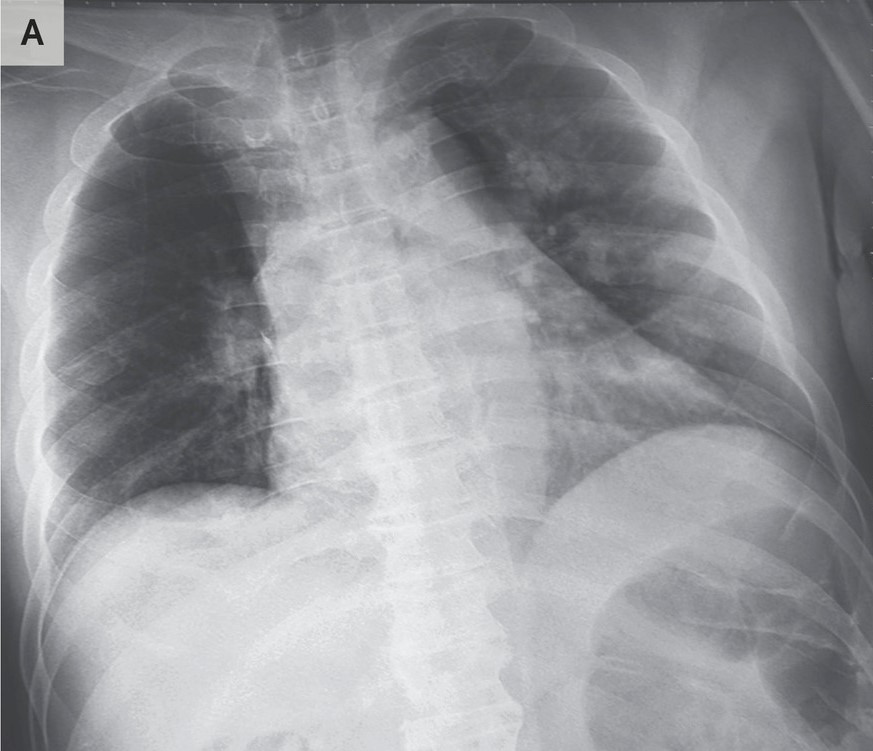

(751, 873, 3)

In [17]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
display(img_loaded)

#Get shape of image file
img_data = img_to_array(img_loaded)
img_data.shape

# Modeling

In [23]:
# Write the building and compiling steps within a function
def build_model(name="Model_1", input_shape=input_shape):
    # Instantatie model
    model = models.Sequential(name=name)
    # Scaling layer
    scaling_layer = layers.Rescaling(1.0/255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [24]:
# Build the model
model1 = build_model()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0   

In [27]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [29]:
# fit the neural network
epochs=20
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=get_callbacks()
)

Epoch 1/20
302/302 [==============================] - 8s 25ms/step - loss: 0.1114 - accuracy: 0.9642 - val_loss: 0.3332 - val_accuracy: 0.9135
Epoch 2/20
302/302 [==============================] - 8s 26ms/step - loss: 0.0951 - accuracy: 0.9671 - val_loss: 0.3534 - val_accuracy: 0.9041
Epoch 3/20
302/302 [==============================] - 8s 25ms/step - loss: 0.0720 - accuracy: 0.9785 - val_loss: 0.3814 - val_accuracy: 0.9070
Epoch 4/20
302/302 [==============================] - 8s 25ms/step - loss: 0.0576 - accuracy: 0.9847 - val_loss: 0.3933 - val_accuracy: 0.9128



- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1595
           1       0.99      0.98      0.99      1618
           2       1.00      0.99      0.99      1619

    accuracy                           0.99      4832
   macro avg       0.99      0.99      0.99      4832
weighted avg       0.99      0.99      0.99      4832



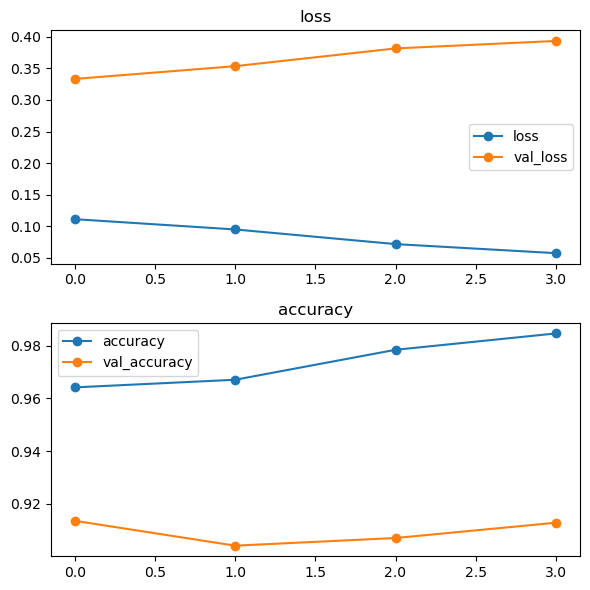

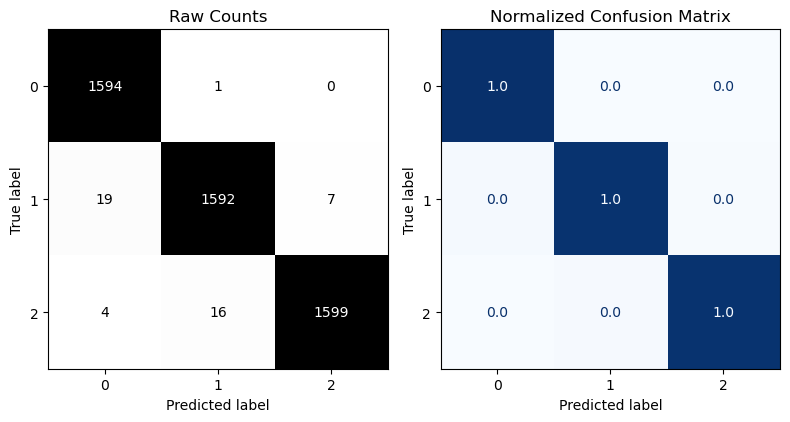


- Evaluating Training Data:
302/302 [==============================] - 3s 9ms/step - loss: 0.0394 - accuracy: 0.9903
{'loss': 0.039423394948244095, 'accuracy': 0.9902731776237488}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       209
           1       0.90      0.86      0.88       259
           2       0.90      0.88      0.89       226

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.90      0.90      0.90       694



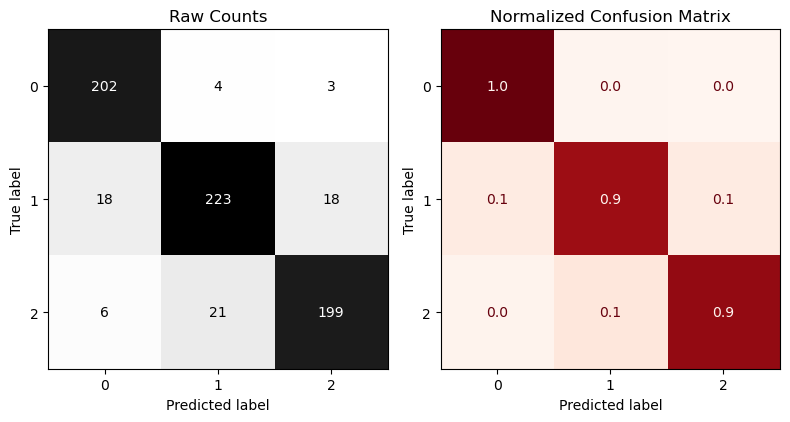


- Evaluating Test Data:
44/44 [==============================] - 0s 8ms/step - loss: 0.4325 - accuracy: 0.8991
{'loss': 0.43245458602905273, 'accuracy': 0.8991354703903198}


In [30]:
# Use evaluation function
evaluate_classification_network(
    model1,
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(8, 8),
    values_format=".1f");

# Tuning CNNs

In [28]:
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

import os

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [31]:
def build_model_dense():
    model = models.Sequential(name='tuning-cnn1')
    model.add(layers.Rescaling(1. / 255, input_shape=input_shape))
    # Conv2d/MaxPooling #1
    model.add(layers.Conv2D(16, kernel_size=3, padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    # Conv2d/MaxPooling #2
    model.add(layers.Conv2D(32, kernel_size=3,padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    model.add(layers.Flatten())
    ## NEW Hidden Dense layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"]
    )
    return model

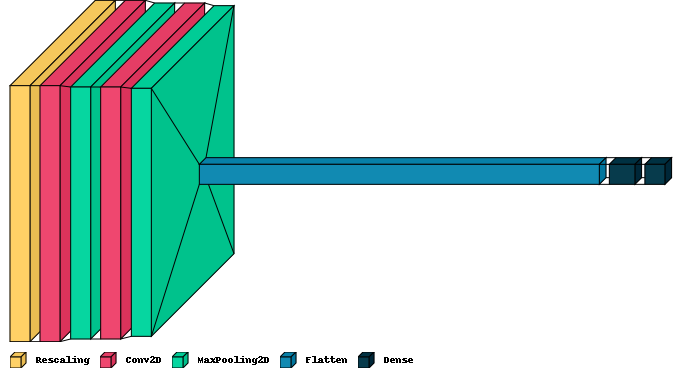

Model: "tuning-cnn1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 63, 63, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 123008)            

In [32]:
model2 = build_model_dense()
display(vk.layered_view(model2, legend=True))
model2.summary()
# fit the neural network
history = model2.fit(
    train_ds, validation_data=val_ds, epochs=20, callbacks=get_callbacks(patience=5)
)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1595
           1       1.00      1.00      1.00      1618
           2       1.00      1.00      1.00      1619

    accuracy                           1.00      4832
   macro avg       1.00      1.00      1.00      4832
weighted avg       1.00      1.00      1.00      4832



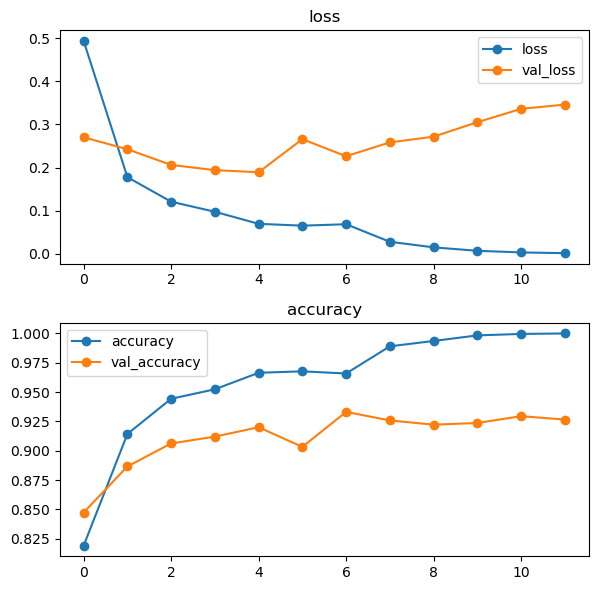

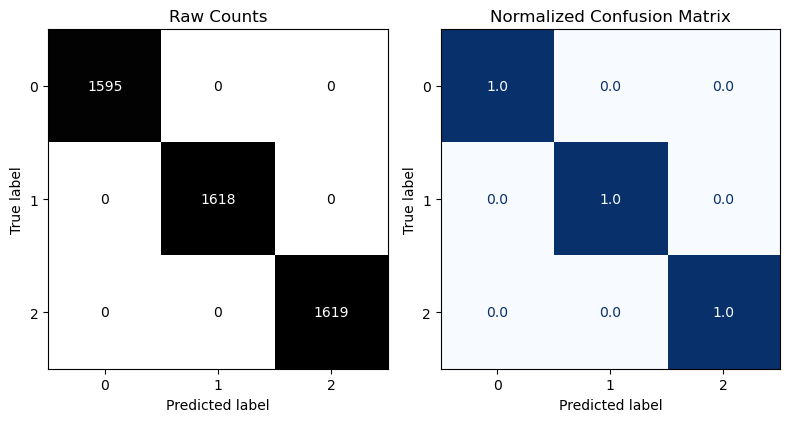


- Evaluating Training Data:
302/302 [==============================] - 8s 25ms/step - loss: 7.0861e-04 - accuracy: 1.0000
{'loss': 0.000708606734406203, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       209
           1       0.88      0.92      0.90       259
           2       0.93      0.88      0.90       226

    accuracy                           0.92       694
   macro avg       0.92      0.92      0.92       694
weighted avg       0.92      0.92      0.92       694



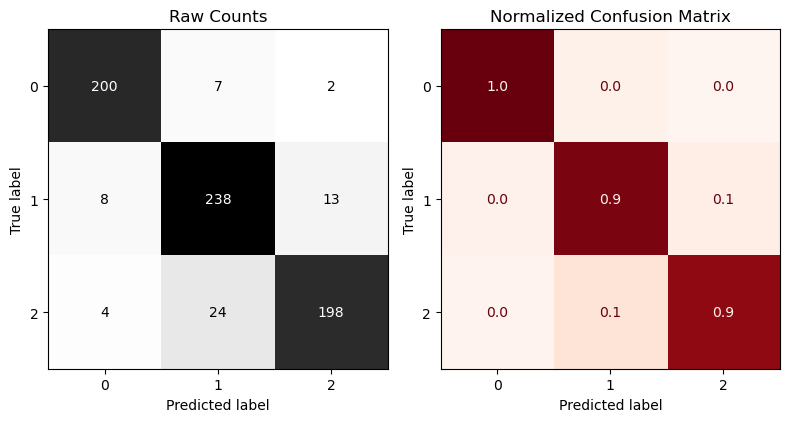


- Evaluating Test Data:
44/44 [==============================] - 1s 23ms/step - loss: 0.4060 - accuracy: 0.9164
{'loss': 0.40595415234565735, 'accuracy': 0.9164265394210815}


In [33]:
# Use evaluation function
evaluate_classification_network(
    model2,
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(8, 8),
    values_format=".1f");

# Transfer Learning

In [34]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape=input_shape)
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

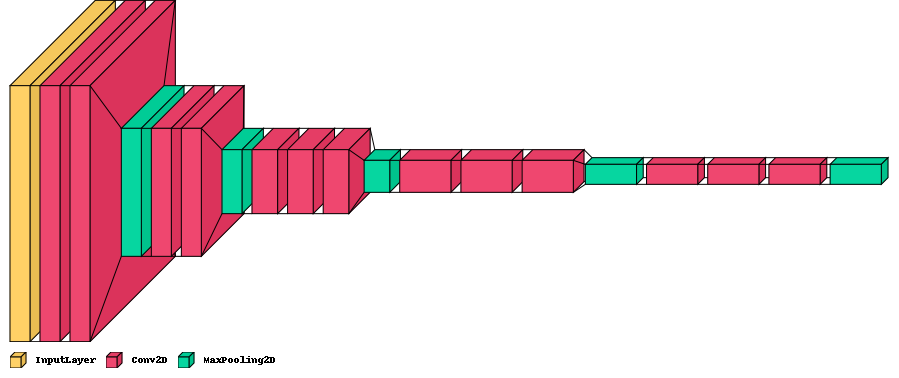

In [35]:
# Visualize the model with visualkeras
vk.layered_view(vgg16_base, legend=True)

In [36]:
# Check if base is trainable
vgg16_base.trainable

True

In [37]:
# Prevent layers from base_model from changing
vgg16_base.trainable = False
vgg16_base.trainable

False

In [38]:
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,name='preprocess_input')
lambda_layer_vgg16

In [39]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)


def build_vgg16_model():
    model = models.Sequential(name="VGG16")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [40]:
def get_callbacks(monitor='val_accuracy', patience=3, restore_best_weights=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                      restore_best_weights=restore_best_weights)
    return [early_stopping]

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 64, 64, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 525,315
Non-traina

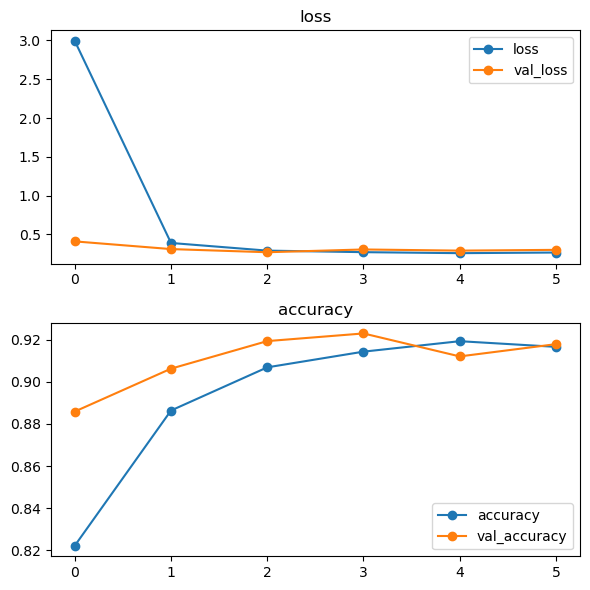

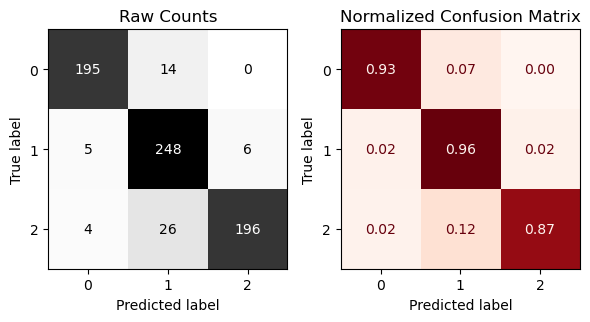


- Evaluating Test Data:
44/44 [==============================] - 7s 163ms/step - loss: 0.2556 - accuracy: 0.9207
{'loss': 0.2556372284889221, 'accuracy': 0.920749306678772}


In [41]:
model_vgg16=build_vgg16_model()
history = model_vgg16.fit(train_ds, validation_data=val_ds,epochs=20, 
                    callbacks=get_callbacks()
                         )
evaluate_classification_network(model_vgg16,X_test=test_ds,history=history);

# Chosen Model

### Our first basic model didn't gain much in accuracy and loss only mounted so the model ran till early stopping patience.
### The second model tuned with a thick 256 layer at least improved across the first few epochs. However, accuracy plateaued after 6th epoch and loss started rising again.
### The third model with the pretrained VGG16 network has a slight increase in accuracy over the tuned model and less loss as well. Unlike the other models it doesn't appear to be getting significantly worse over time although only five epochs ran since early stopping recognized loss hadn't improved. Testing evaluation was also most favorable for VGG16 with loss ~0.25, significantly less than 0.43 and 0.4 of previous models. The third model should be chosen going forward.